In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from functools import reduce
from scipy import stats

from kmodes.kmodes import KModes
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


# Feature selection - Use of Chi-squared as method of selection (Dataset consists of Categorical Variables)
def select_features(X, y):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit_transform(X, y)

    return fs

# Feature Selection Score Graph Visualization
def selectK (features, predictor):
    X = features
    y = predictor
    #Apply Feature Selection Function to the dataset 
    fs = select_features(X,y)
    
    #Printing Score
    for i in range(len(fs.scores_)):
        print('Feature %d: %f' % (i, fs.scores_[i]))
        
    #Plot Feature Selection Score
    pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
    return pyplot.show()

#Selecting Top 5 Features  
def top5_features(fs, dataset):
    
    top_5_ind = []
    for key, val in sorted(zip(fs.scores_,range(len(fs.scores_))), reverse=True):
        top_5_ind.append([key, val])
        top_5_ind = top_5_ind[:5]
        
    top_feat = {}
    top_feat_ls = []
    for i in range(len(top_5_ind)):
        top_feat[dataset.columns[top_5_ind[i][1]]] = top_5_ind[i][0]
        top_feat_ls.append(dataset.columns[top_5_ind[i][1]])
        df = dataset[top_feat_ls]

        print('Top5 Feature:{},{}'.format(dataset.columns[top_5_ind[i][1]], top_5_ind[i][0]))
    
    return df

# Function that provides a Elbow Plot to illustrate the best K selection
def k_mode (dataset, num_k):
    cost = []
    K = range(1,num_k) # will be looping  K = 1 -> 5
    for num_clusters in list(K):
        kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=0)
        kmode.fit_predict(dataset)
        cost.append(kmode.cost_) #Cost Function for each K
    
    plt.plot(K, cost, 'bx-')
    plt.xlabel('No. of clusters')
    plt.ylabel('Cost')
    plt.title('Elbow Method For Optimal k')
    return plt.show()

#When the optimal K is found, create a dataframe
def k_mode_compute__(dataset,num_k):
    kmode = KModes(n_clusters=num_k, init = "random", n_init = 5, verbose=0)
    clusters = kmode.fit_predict(dataset)
    a = pd.DataFrame(clusters)
    
    return a.iloc[:,0].value_counts().to_frame(), a.reset_index()
  
#Monte Carlo Simulation
def simulation(input_dataframe, num_k, num_iteration):
    freq = [] # Value_counts for n_clusters (Total No. of Samples for Each Cluster for Each iteration)
    sample = [] # 5800 Samples with label- nth_Cluster
    
    for _ in range(0,num_iteration):
        km = k_mode_compute__(input_dataframe,num_k)
        freq.append(km[0])
        sample.append(km[1])
    
    # combining Value_counts df for 100 simulation
    data_frames = freq[:]
    result = reduce(lambda df_left,df_right: pd.merge(df_left, df_right, 
                                            left_index=True, right_index=True, #on=['index'],
                                            how='outer'),data_frames)
    return freq, sample, result

#Graphical Visualization of Simulation Result
def monte_carlo_vis(simulation_result, nth_cluster):
    #Normal Distribution Tranformation
    data = simulation_result.iloc[nth_cluster].values
    
    fit_data, fit_lambda = stats.boxcox(data)
    
    mean = int(np.mean(data))
    std = int(np.std(data))
    
    area = []
    for ind, val  in enumerate(data):
        if val in range(mean-std, mean+std):
            area.append(ind)
    
    
    original = sns.distplot(fit_data, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, color ="green")
    
    near_mean = sns.distplot(fit_data[area], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, color ="red")
    
    return original, near_mean

# Finding the Opitmal Clustering Combination Obtained from the Simulation
def optimal_cluster(simulation_result, sample):

    cl1 = []
    cl2 = []
    cl3 = []
    #Computing the Distance from the Mean (Finding the Optimal Cluster)
    for i in simulation_result.iloc[0].values:
        cl1.append(abs(i - simulation_result.iloc[0].mean()))
    for j in simulation_result.iloc[1].values:
        cl2.append(abs(j - simulation_result.iloc[1].mean()))
    for k in simulation_result.iloc[2].values:
        cl3.append(abs(k - simulation_result.iloc[2].mean()))
    
    final = zip(cl1,cl2,cl3)
    final_ = [round(sum(item),2) for item in final]
    
    #Creating a Dataframe (Opitmal Cluster)
    best_val = sample[np.where(min(final_)== final_)[0][0]][0].value_counts()
    best_sample = sample[np.where(min(final_)== final_)[0][0]]
    
    return best_val, best_sample

# K-Mode Functions

## Importing Data

In [3]:
df = pd.read_csv('processed.csv')
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [4]:
df

,scenario,bichoice,comb,priceprop,range,home_chg,work_chg,fasttime,town,highway,...,used_car_owner,used_ev_owner,used,numprice,PopDensity,orphan,ev_owner,freq,priceshow,home_park
0,25,1,6468,0.70,100,0,0,15,2,4,...,1,0,1,10000,290.5478,1,0,6,7000,2
1,44,0,13191,0.70,400,20,3,15,3,3,...,1,0,1,10000,290.5478,1,0,6,7000,2
2,10,1,21921,0.70,200,0,10,30,3,2,...,1,0,1,10000,290.5478,1,0,6,7000,2
3,35,1,32501,0.85,300,0,10,5,3,1,...,1,0,1,10000,290.5478,1,0,6,8500,2
4,111,0,12360,0.70,100,20,20,30,3,3,...,1,0,1,10000,290.5478,1,0,6,7000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5797,54,0,36184,1.00,300,1,3,30,1,1,...,0,0,0,40000,745.2866,1,0,6,40000,1
5798,101,0,32245,1.00,400,0,1,15,3,1,...,0,0,0,40000,745.2866,1,0,6,40000,1
5799,39,0,17817,0.70,200,20,5,15,1,3,...,0,0,0,40000,745.2866,1,0,6,28000,1
5800,16,0,20680,1.00,300,10,10,5,4,2,...,0,0,0,40000,745.2866,1,0,6,40000,1


In [5]:
#from the entire dataset, choosing specific columns that represents the socio-economic background.
pi = df[['gender','state_answer','edu','employment','hsincome','hhsize','age','license','housit','residence','move','work_parking','home_park','orphan']]

## Feature Selection

The function uses chi-squared feature selection method to visualizer the feature importance score

Feature 0: 16.465468
Feature 1: 7.445104
Feature 2: 2.684227
Feature 3: 1.028252
Feature 4: 0.609504
Feature 5: 5.675016
Feature 6: 17.540413
Feature 7: 0.000989
Feature 8: 0.000057
Feature 9: 5.948883
Feature 10: 0.009033
Feature 11: 8.768291
Feature 12: 0.053032
Feature 13: 0.659022


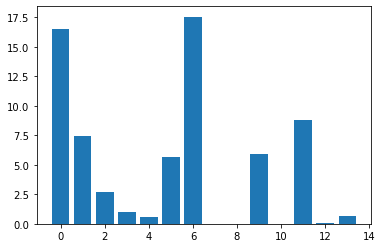

In [6]:
selectK(pi,df['bichoice'])

Selecting Top 5 features based on the above function, dataframe will be created

In [7]:
#feature score computing
fs = select_features(pi, df['bichoice'])

In [8]:
selected_df = top5_features(fs, pi)

Top5 Feature:age,17.540412916958445
Top5 Feature:gender,16.46546776978813
Top5 Feature:work_parking,8.768290985334266
Top5 Feature:state_answer,7.445104172693558
Top5 Feature:residence,5.94888304469447


In [9]:
#Resulting dataframe
selected_df.head()

,age,gender,work_parking,state_answer,residence
0,3,0,4,44,5
1,3,0,4,44,5
2,3,0,4,44,5
3,3,0,4,44,5
4,3,0,4,44,5


## Seleting Optimal K 

Elbow curve is used to visualize and choose the optimal K for K-mode selection

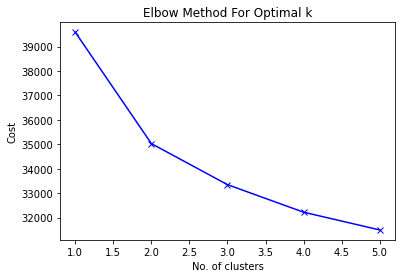

In [10]:
#Elbow Curve function 
k_mode(pi, 6)

Base on the Elbow curve, k=3 is chosen and will be computed 

In [11]:
#Input to the function: Dataset, number of k selected
km = k_mode_compute__(pi, 3)

## Simulation

Because there are many features involved and each features have multiple classes, it will be hard for k-mode algorithm to seperate them into 3 total clusters only. Running K-mode many times will show the  optimal probability that represents the population

In [12]:
# Monte Carlo Simulation (Running 100 Times)
freq, sample, sim_result = simulation(input_dataframe=selected_df, num_k=3, num_iteration=100)

In [179]:
#Resulting Data from the Simulation
#Row: nth-cluster
#Columns: number of iterations (100 in total)
sim_result

,0_x,0_y,0_x,0_y,0_x,0_y,0_x,0_y,0_x,0_y,...,0_x,0_y,0_x,0_y,0_x,0_y,0_x,0_y,0_x,0_y
0,3480,2562,3390,3678,1458,2748,3018,2376,3810,2184,...,3036,1692,3036,2514,3006,2772,3072,3390,3078,2454
1,1440,2346,1464,1044,2706,1086,2244,2736,852,2484,...,1740,2430,1740,2442,2160,2490,2100,1464,894,1116
2,882,894,948,1080,1638,1968,540,690,1140,1134,...,1026,1680,1026,846,636,540,630,948,1830,2232


Monte Carlo simulation assumes that if iterations are done many times it will be exactly same as the population distribution.
<br>

Greern plot indicates the Distrubtion for 500 iteration simulation
<br>
Red plot indiciated the portion represents the 1 standard deviation

(<matplotlib.axes._subplots.AxesSubplot at 0x1ffdd1bfb20>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ffdd1bfb20>)

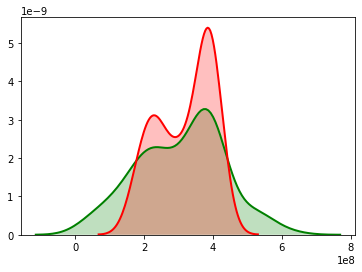

In [13]:
monte_carlo_vis(sim_result,0)

Because we need to pick the optimal cluster combination sepearation and becaus we have utilized box-cox transform to make the distribution Gaussian-like. The optimal combination would be the one that is closeset to the mean

In [14]:
# Seleting the Optimal Clustering by Examining the minimal distance from the mean
best_val, best_sample = optimal_cluster(sim_result, sample)

In [15]:
# Clustering Combination Found out to be the Optimal (Index indicates the nth_cluster)
best_val

0    2994
1    1524
2    1284
Name: 0, dtype: int64

In [23]:
# Sample Data with Cluster Labled
# Index will be used to combine with other dataframe later on to track the sample
best_sample.rename(columns={0:'Cluster'}, inplace=True)
best_sample

,index,Cluster
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
5797,5797,0
5798,5798,0
5799,5799,0
5800,5800,0


In [26]:
merged_df = pd.merge(selected_df.reset_index(), best_sample)
merged_df

,index,age,gender,work_parking,state_answer,residence,Cluster
0,0,3,0,4,44,5,1
1,1,3,0,4,44,5,1
2,2,3,0,4,44,5,1
3,3,3,0,4,44,5,1
4,4,3,0,4,44,5,1
...,...,...,...,...,...,...,...
5797,5797,2,1,2,9,1,0
5798,5798,2,1,2,9,1,0
5799,5799,2,1,2,9,1,0
5800,5800,2,1,2,9,1,0


C:\Users\Wooja\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Wooja\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Wooja\Anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Wooja\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Wooja\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


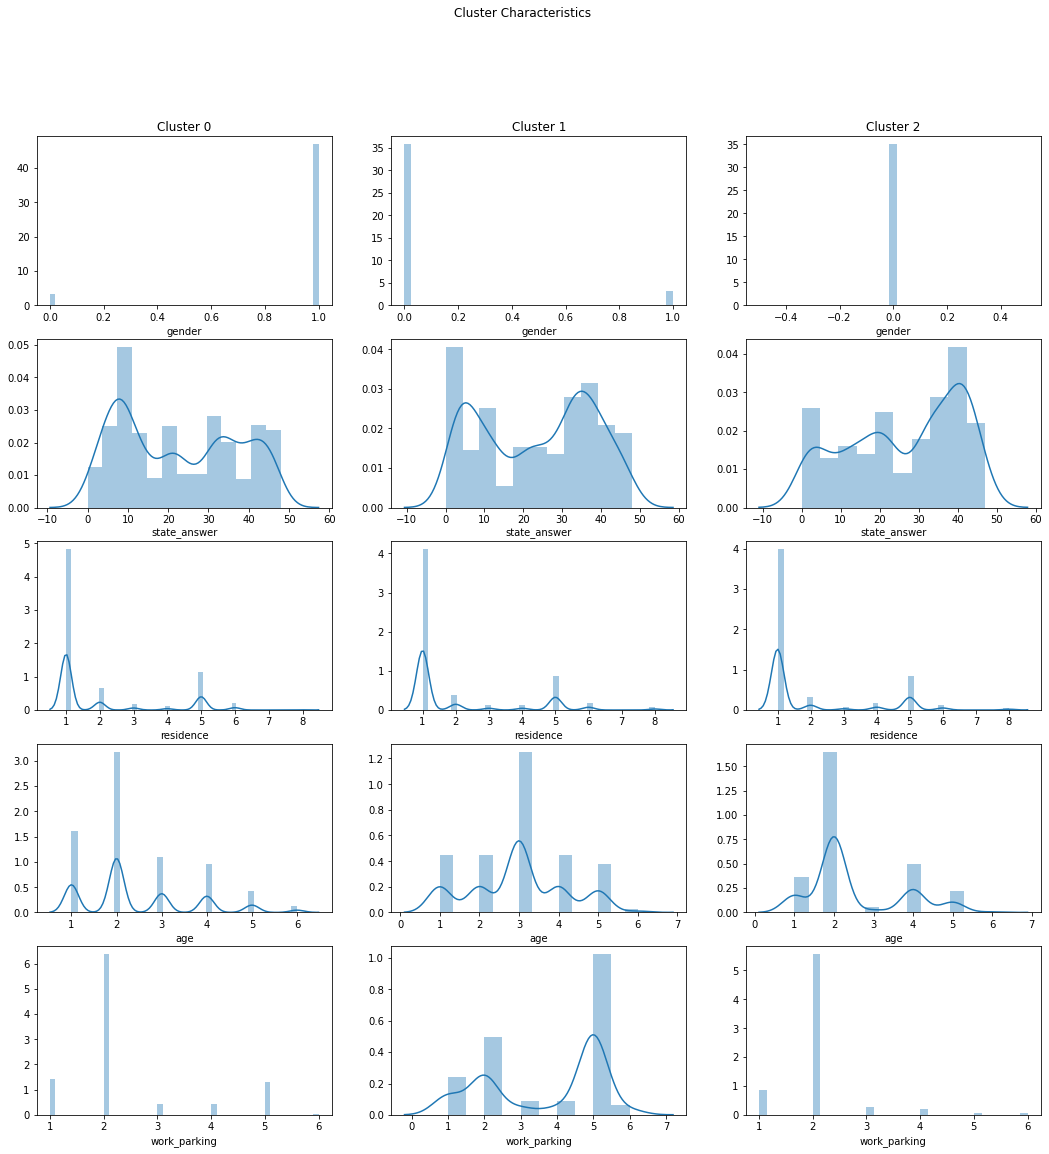

In [30]:
# Visualizing, Characteristics
fig, axes = plt.subplots(5,3, figsize=(18,18))

fig.suptitle('Cluster Characteristics')

axes[0,0].set_title('Cluster 0')
axes[0,1].set_title('Cluster 1')
axes[0,2].set_title('Cluster 2')

sns.distplot(merged_df[merged_df.Cluster==0]['gender'],ax=axes[0,0])
sns.distplot(merged_df[merged_df.Cluster==1]['gender'],ax=axes[0,1])
sns.distplot(merged_df[merged_df.Cluster==2]['gender'],ax=axes[0,2])

sns.distplot(merged_df[merged_df.Cluster==0]['state_answer'],ax=axes[1,0])
sns.distplot(merged_df[merged_df.Cluster==1]['state_answer'],ax=axes[1,1])
sns.distplot(merged_df[merged_df.Cluster==2]['state_answer'],ax=axes[1,2])

sns.distplot(merged_df[merged_df.Cluster==0]['residence'],ax=axes[2,0])
sns.distplot(merged_df[merged_df.Cluster==1]['residence'],ax=axes[2,1])
sns.distplot(merged_df[merged_df.Cluster==2]['residence'],ax=axes[2,2])

sns.distplot(merged_df[merged_df.Cluster==0]['age'],ax=axes[3,0])
sns.distplot(merged_df[merged_df.Cluster==1]['age'],ax=axes[3,1])
sns.distplot(merged_df[merged_df.Cluster==2]['age'],ax=axes[3,2])

sns.distplot(merged_df[merged_df.Cluster==0]['work_parking'],ax=axes[4,0])
sns.distplot(merged_df[merged_df.Cluster==1]['work_parking'],ax=axes[4,1])
sns.distplot(merged_df[merged_df.Cluster==2]['work_parking'],ax=axes[4,2])

The same procedure will be done with 2 different sections - Vehicle Usage and Charging Infrastructure 

In [31]:
# Vehicle Usage Behavior Section
vuse = df[['dmileage','long_dist','gascost']]

Feature 0: 2.806579
Feature 1: 0.218134
Feature 2: 0.034617


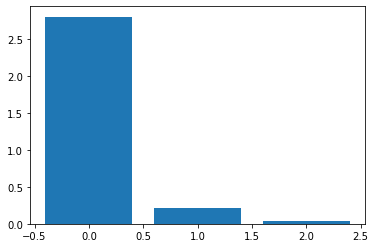

In [32]:
selectK(vuse,df['bichoice'])

In [33]:
#feature score computing
fs = select_features(vuse, df['bichoice'])

In [34]:
selected_df = top5_features(fs, vuse)
#Resulting dataframe
selected_df.head()

Top5 Feature:dmileage,2.806579383868116
Top5 Feature:long_dist,0.21813427381741823
Top5 Feature:gascost,0.034616990871977796


,dmileage,long_dist,gascost
0,25,1,1
1,25,1,1
2,25,1,1
3,25,1,1
4,25,1,1


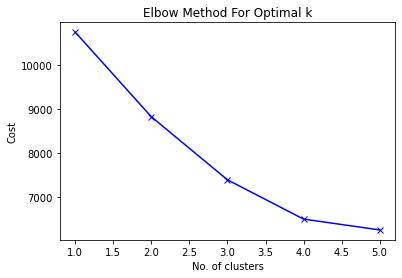

In [35]:
#Elbow Curve function 
k_mode(vuse, 6)

In [36]:
#Input to the function: Dataset, number of k selected
km = k_mode_compute__(vuse, 3)

In [37]:
# Monte Carlo Simulation (Running 100 Times)
freq, sample, sim_result = simulation(input_dataframe=selected_df, num_k=3, num_iteration=100)

(<matplotlib.axes._subplots.AxesSubplot at 0x1ffdd0fd8b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ffdd0fd8b0>)

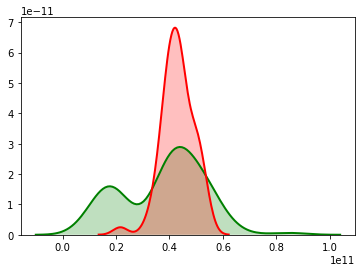

In [38]:
monte_carlo_vis(sim_result,0)

In [39]:
best_val, best_sample = optimal_cluster(sim_result, sample)
best_val

0    2892
1    1710
2    1200
Name: 0, dtype: int64

In [40]:
best_sample.rename(columns={0:'Cluster'}, inplace=True)
best_sample

,index,Cluster
0,0,2
1,1,2
2,2,2
3,3,2
4,4,2
...,...,...
5797,5797,0
5798,5798,0
5799,5799,0
5800,5800,0


In [41]:
merged_df = pd.merge(selected_df.reset_index(), best_sample)
merged_df

,index,dmileage,long_dist,gascost,Cluster
0,0,25,1,1,2
1,1,25,1,1,2
2,2,25,1,1,2
3,3,25,1,1,2
4,4,25,1,1,2
...,...,...,...,...,...
5797,5797,10,0,1,0
5798,5798,10,0,1,0
5799,5799,10,0,1,0
5800,5800,10,0,1,0


C:\Users\Wooja\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Wooja\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Wooja\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


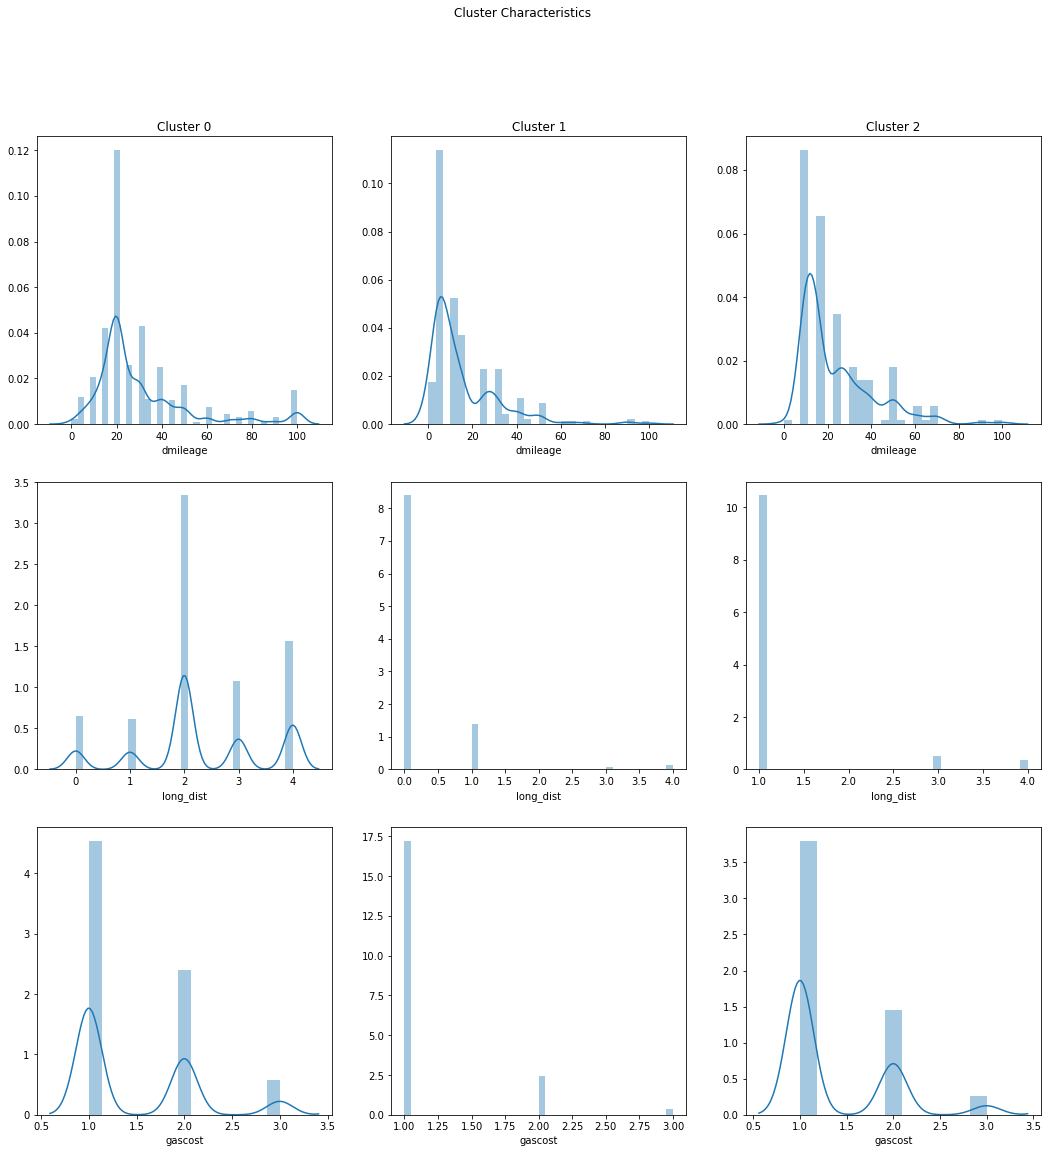

In [61]:
fig, axes = plt.subplots(3,3, figsize=(18,18))

fig.suptitle('Cluster Characteristics')

axes[0,0].set_title('Cluster 0')
axes[0,1].set_title('Cluster 1')
axes[0,2].set_title('Cluster 2')

sns.distplot(merged_df[merged_df.Cluster==0]['dmileage'],ax=axes[0,0])
sns.distplot(merged_df[merged_df.Cluster==1]['dmileage'],ax=axes[0,1])
sns.distplot(merged_df[merged_df.Cluster==2]['dmileage'],ax=axes[0,2])

sns.distplot(merged_df[merged_df.Cluster==0]['long_dist'],ax=axes[1,0])
sns.distplot(merged_df[merged_df.Cluster==1]['long_dist'],ax=axes[1,1])
sns.distplot(merged_df[merged_df.Cluster==2]['long_dist'],ax=axes[1,2])

sns.distplot(merged_df[merged_df.Cluster==0]['gascost'],ax=axes[2,0])
sns.distplot(merged_df[merged_df.Cluster==1]['gascost'],ax=axes[2,1])
sns.distplot(merged_df[merged_df.Cluster==2]['gascost'],ax=axes[2,2])

In [62]:
# Charging Infra 
charge = df[['home_chg','work_chg','fasttime','town','highway','home_evse','work_evse']]

Feature 0: 218.338532
Feature 1: 164.032770
Feature 2: 53.448149
Feature 3: 32.417214
Feature 4: 0.218315
Feature 5: 0.249262
Feature 6: 2.721200


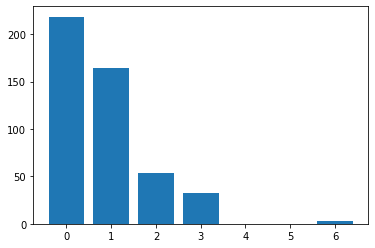

In [63]:
selectK(charge,df['bichoice'])

In [64]:
#feature score computing
fs = select_features(charge, df['bichoice'])

In [65]:
selected_df = top5_features(fs, charge)
#Resulting dataframe
selected_df.head()

Top5 Feature:home_chg,218.33853219850442
Top5 Feature:work_chg,164.03277039292513
Top5 Feature:fasttime,53.448148699369554
Top5 Feature:town,32.41721394263621
Top5 Feature:work_evse,2.721199873551096


,home_chg,work_chg,fasttime,town,work_evse
0,0,0,15,2,2
1,20,3,15,3,2
2,0,10,30,3,2
3,0,10,5,3,2
4,20,20,30,3,2


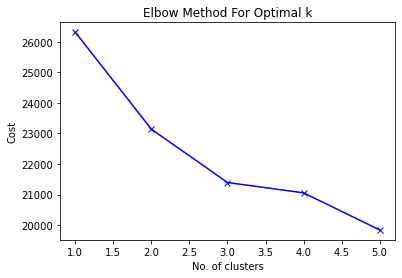

In [66]:
#Elbow Curve function 
k_mode(charge, 6)

In [67]:
#Input to the function: Dataset, number of k selected
km = k_mode_compute__(charge, 3)

In [68]:
# Monte Carlo Simulation (Running 100 Times)
freq, sample, sim_result = simulation(input_dataframe=selected_df, num_k=3, num_iteration=100)

(<matplotlib.axes._subplots.AxesSubplot at 0x1ffe06b7190>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ffe06b7190>)

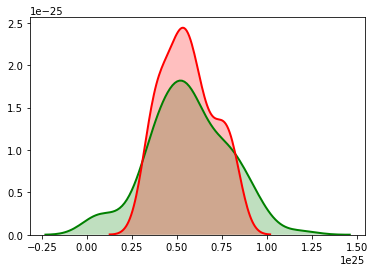

In [69]:
monte_carlo_vis(sim_result,0)

In [70]:
best_val, best_sample = optimal_cluster(sim_result, sample)
best_val

0    2885
1    1744
2    1173
Name: 0, dtype: int64

In [71]:
best_sample.rename(columns={0:'Cluster'}, inplace=True)
best_sample

,index,Cluster
0,0,1
1,1,1
2,2,1
3,3,1
4,4,0
...,...,...
5797,5797,2
5798,5798,1
5799,5799,0
5800,5800,0


In [72]:
merged_df = pd.merge(selected_df.reset_index(), best_sample)
merged_df

,index,home_chg,work_chg,fasttime,town,work_evse,Cluster
0,0,0,0,15,2,2,1
1,1,20,3,15,3,2,1
2,2,0,10,30,3,2,1
3,3,0,10,5,3,2,1
4,4,20,20,30,3,2,0
...,...,...,...,...,...,...,...
5797,5797,1,3,30,1,2,2
5798,5798,0,1,15,3,2,1
5799,5799,20,5,15,1,2,0
5800,5800,10,10,5,4,2,0


C:\Users\Wooja\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


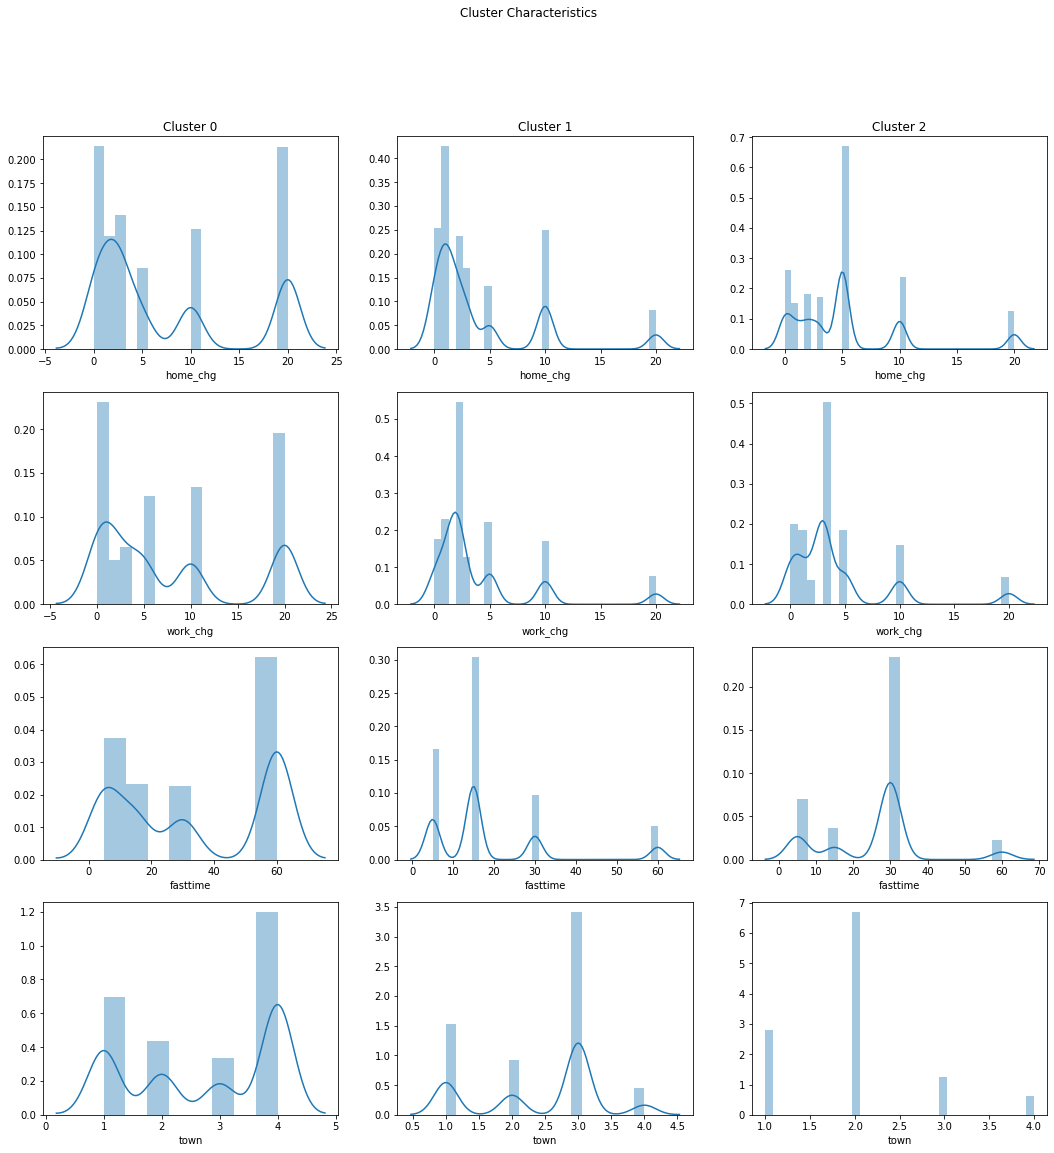

In [73]:
fig, axes = plt.subplots(4,3, figsize=(18,18))

fig.suptitle('Cluster Characteristics')

axes[0,0].set_title('Cluster 0')
axes[0,1].set_title('Cluster 1')
axes[0,2].set_title('Cluster 2')

sns.distplot(merged_df[merged_df.Cluster==0]['home_chg'],ax=axes[0,0])
sns.distplot(merged_df[merged_df.Cluster==1]['home_chg'],ax=axes[0,1])
sns.distplot(merged_df[merged_df.Cluster==2]['home_chg'],ax=axes[0,2])
merged_df
sns.distplot(merged_df[merged_df.Cluster==0]['work_chg'],ax=axes[1,0])
sns.distplot(merged_df[merged_df.Cluster==1]['work_chg'],ax=axes[1,1])
sns.distplot(merged_df[merged_df.Cluster==2]['work_chg'],ax=axes[1,2])

sns.distplot(merged_df[merged_df.Cluster==0]['fasttime'],ax=axes[2,0])
sns.distplot(merged_df[merged_df.Cluster==1]['fasttime'],ax=axes[2,1])
sns.distplot(merged_df[merged_df.Cluster==2]['fasttime'],ax=axes[2,2])
merged_df
sns.distplot(merged_df[merged_df.Cluster==0]['town'],ax=axes[3,0])
sns.distplot(merged_df[merged_df.Cluster==1]['town'],ax=axes[3,1])
sns.distplot(merged_df[merged_df.Cluster==2]['town'],ax=axes[3,2])